Performing GridSearchCV for Logistic Regression...
Best parameters for Logistic Regression: {'C': 1}
Best cross-validated accuracy for Logistic Regression: 0.9923076923076923

Performing GridSearchCV for Support Vector Machine...
Best parameters for Support Vector Machine: {'C': 100, 'gamma': 0.01}
Best cross-validated accuracy for Support Vector Machine: 0.9923076923076923

Performing GridSearchCV for K-Nearest Neighbors...
Best parameters for K-Nearest Neighbors: {'n_neighbors': 3}
Best cross-validated accuracy for K-Nearest Neighbors: 0.9692307692307691


--- Logistic Regression ---
Accuracy on test data: 0.984375
Confusion Matrix:
[[27  1  0]
 [ 0 16  0]
 [ 0  0 20]]

--- Support Vector Machine ---
Accuracy on test data: 0.96875
Confusion Matrix:
[[27  1  0]
 [ 0 15  1]
 [ 0  0 20]]

--- K-Nearest Neighbors ---
Accuracy on test data: 0.984375
Confusion Matrix:
[[27  1  0]
 [ 0 16  0]
 [ 0  0 20]]


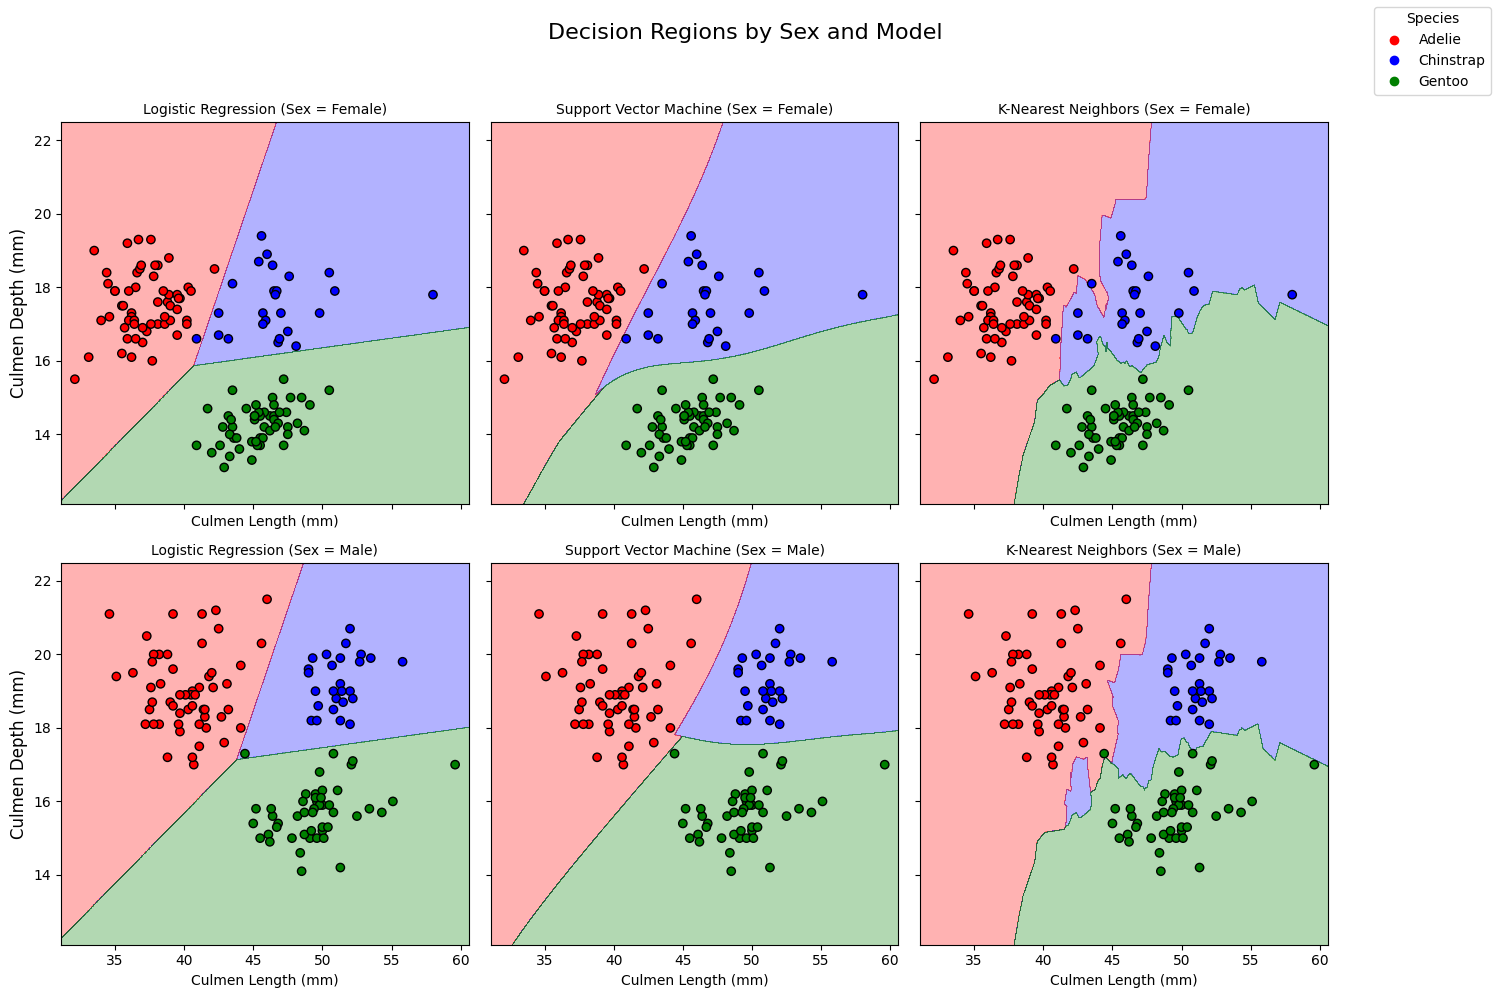

In [ ]:
# Import modules from sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV

# Using LabelEncoder(), encode 'Sex' and 'Species'
# Initalize the label encoder for 'Sex'
sex_encoder = LabelEncoder()
# Encode the 'Sex' column in the training data
X_train_cleaned["Sex"] = sex_encoder.fit_transform(X_train_cleaned["Sex"])
# Encode the 'Sex' column in the testing data
X_test_cleaned["Sex"] = sex_encoder.transform(X_test_cleaned["Sex"])
# Initialize the label encoder for 'Species'
species_encoder = LabelEncoder()
# Encode the 'Species' column in the training data
y_train_encoded = species_encoder.fit_transform(y_train_cleaned)
# Encode the 'Species' column in the testing data
y_test_encoded = species_encoder.transform(y_test_cleaned)

# Using the StandardScaler module, standardize quantitative features
scaler = StandardScaler()
# Choose the features for the modeling section from cleaned training data
X_train_model = X_train_cleaned[["Sex", "Culmen Length (mm)", "Culmen Depth (mm)"]]
# Choose the features for the modeling section from cleaned testing data
X_test_model = X_test_cleaned[["Sex", "Culmen Length (mm)", "Culmen Depth (mm)"]]

# Define the hyperparameter grids for each of the models
param_grids = {
    "Logistic Regression": {"C": [0.01, 0.1, 1, 10, 100]}, # Regularization strength
    "Support Vector Machine": {"C": [0.01, 0.1, 1, 10, 100], "gamma": [0.001, 0.01, 0.1, 1, 10]}, # Number of neighbors
    "K-Nearest Neighbors": {"n_neighbors": [3, 5, 7, 9, 11]} # Number of neighbors
}

# Define the base models
base_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000), # Logistic regression
    "Support Vector Machine": SVC(), # Support vector classifier
    "K-Nearest Neighbors": KNeighborsClassifier() # K-Nearest neighbors model
}

# Find the best hyperparameters by using GridSearchCV
best_models = {} # Initialize empty dictionary to store best models
for name, model in base_models.items():
    # Print the current model
    print(f"Performing GridSearchCV for {name}...")
    # Initialize GridSearchCV with model and parameter grid
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=5, scoring="accuracy")
    # Fit to training data
    grid_search.fit(X_train_model, y_train_encoded)
    # Obtain the best model
    best_models[name] = grid_search.best_estimator_  # Store the best model
    # Print best parameters
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    # Print cross-validated accuracy
    print(f"Best cross-validated accuracy for {name}: {grid_search.best_score_}\n")

# Evaluate the models for the testing data
results = {} # Initialize an empty dictionary to the store the results
for name, model in best_models.items():
    # Predict the test data labels
    y_pred = model.predict(X_test_model)

    # Obtain accuracy score and confusion matrix
    acc = accuracy_score(y_test_encoded, y_pred) # Calculate accuracy score
    conf_matrix = confusion_matrix(y_test_encoded, y_pred) # Calculate confusion matrix

    # Store results in the results dictionary
    results[name] = {
        "Model": model,
        "Accuracy": acc,
        "Confusion Matrix": conf_matrix
    }
    # Print the results
    print(f"\n--- {name} ---")
    print(f"Accuracy on test data: {acc}")
    print("Confusion Matrix:")
    print(conf_matrix)

# Extract trained models from the dictionary to use to plot
trained_models = {name: data["Model"] for name, data in results.items()}

# Define function plot_decision_regions_by_sex to plot the decision regions
def plot_decision_regions_by_sex(X, y, models, qualitative_col, qualitative_values, encoder):
    """
    Plots the decision regions for each model, grouped by values of the qualitative feature.
    """
    # Create subplots
    fig, axes = plt.subplots(len(qualitative_values), len(models), figsize=(15, 10), sharex=True, sharey=True)
    qualitative_map = {0: 'Female', 1: 'Male'} # Qualitative feature mapping

    # Define the global range for meshgrid across all qualitative values
    x1_min, x1_max = X["Culmen Length (mm)"].min() - 1, X["Culmen Length (mm)"].max() + 1
    x2_min, x2_max = X["Culmen Depth (mm)"].min() - 1, X["Culmen Depth (mm)"].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.01),
                           np.arange(x2_min, x2_max, 0.01))

    # Loop through the qualitative values
    for i, qualitative_value in enumerate(qualitative_values):
        # Filter training data based on the qualitative feature value
        X_filtered = X[X[qualitative_col] == qualitative_value]
        y_filtered = y[X[qualitative_col] == qualitative_value]

        # Loop through all of the models
        for j, (name, model) in enumerate(models.items()):
            # Obtain the current subplot
            ax = axes[i, j]

            # Add the qualitative feature to the meshgrid
            fixed_qual_col = np.full(xx1.ravel().shape, qualitative_value)
            grid_data = pd.DataFrame({
                "Sex": fixed_qual_col,
                "Culmen Length (mm)": xx1.ravel(),
                "Culmen Depth (mm)": xx2.ravel()
            })

            # Predict the meshgrid labels
            Z = model.predict(grid_data)
            Z = Z.reshape(xx1.shape)

            # Plot the decision boundary with contour plot
            colors = ('red', 'blue', 'green') # Set colors for decision regions
            cmap = ListedColormap(colors[:len(np.unique(y))]) # Make a colormap
            ax.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap) # Plot the decision regions

            # Plot the scatter points for the filtered data
            X_quant = X_filtered[["Culmen Length (mm)", "Culmen Depth (mm)"]].to_numpy()
            scatter = ax.scatter(X_quant[:, 0], X_quant[:, 1], c=y_filtered, edgecolor='k', cmap=cmap)

            # Set the title of the subplot
            title = f"{name} (Sex = {qualitative_map[qualitative_value]})"
            ax.set_title(title, fontsize=10)
            # Set the labels of the subplot
            if j == 0:
                ax.set_ylabel(f"Sex = {qualitative_map[qualitative_value]}", fontsize=12)
            ax.set_xlabel("Culmen Length (mm)")
            ax.set_ylabel("Culmen Depth (mm)" if j == 0 else "")

    # Add a global legend containing the species names
    # Obtain the species names
    species_names = encoder.inverse_transform(np.unique(y)).tolist()
    # Add legends to the figure
    fig.legend(handles=scatter.legend_elements()[0], labels=species_names,
               loc="upper right", title="Species")
    # Add an overall/global title
    fig.suptitle("Decision Regions by Sex and Model", fontsize=16)
    # Tighten the layout
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    # Display plot
    plt.show()

# Call the function plot_decision_regions_by_sex for all of the models
plot_decision_regions_by_sex(
    X_train_model, y_train_encoded,
    models=trained_models, # Use encoded labels as well as training data
    qualitative_col="Sex", # Qualitative feature (Sex)
    qualitative_values=[0, 1],  # 0: Female, 1: Male
    encoder=species_encoder  # Pass the label encoder for the species
)